In [2]:
import hyperspy.api as hs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import arviz as az
import pymc as pm
import pytensor.tensor as pt
import scipy.stats as stats
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
def dataimporter(filename,header=70):
    # Reading in the data file, removing header and converting it to a matrix
    data = pd.read_csv(filename, header=header)
    nummer = data.to_numpy()
    nummerdata = np.asarray(nummer[:-1,:], dtype="float")
    return nummerdata
def plotter(ax,data,zo,colour,label,alpha = 1):
    # Function to plot spectrum
    ax.plot(data[:,0],data[:,1],zorder=zo, lw = 4, color = colour, label =label,alpha=alpha)
    ax.fill_between(data[:,0],data[:,1],zorder=zo, color = colour,alpha=alpha)
   
def find_nearest(array, value):
    # Function for finding closest value in array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def data_integration(data,under=2.2,over=2.6,avgunder=2.65,avgover=2.8 ):
    # Function to integrate the data between energies
    array = np.array([])
    for i in (data):
        intunder = np.where(i[:,0]==find_nearest(i[:,0],under))
        intover = np.where(i[:,0]==find_nearest(i[:,0],over))
        placeunder = np.where(i[:,0]==find_nearest(i[:,0],avgunder))
        placeover = np.where(i[:,0]==find_nearest(i[:,0],avgover))
        
        intunder = np.reshape(intunder,-1)
        intover = np.reshape(intover,-1)
        placeunder = np.reshape(placeunder, -1)
        placeover = np.reshape(placeover, -1)

        # i[:,1] = i[:,1]-np.average(i[placeunder[0]:placeover[0],1])

        top1 = np.sum(i[intunder[0]:intover[0],1])
        array = np.append(array,top1)
    return array

def predict(signal,c):
    return c[0]*signal + c[1]

def readfile(arraynames):
    # Funstion to make it possible to import multiple files at the same time
    meaner = np.array([])
    for i in arraynames:
        temp = dataimporter(i)
        meaner = np.append(meaner,data_integration([temp]))
    return meaner

def read_mapp_file(filepath):
    s = hs.load(filepath).as_signal1D(0)
    s.set_signal_type('EDS_SEM')
    s.set_elements(["O","S","Mo","Si"])
    s.axes_manager.signal_axes[0].units = 'keV'
    s.axes_manager[2].scale = 0.01
    
    
    thickenss = np.zeros([s.data.shape[0],s.data.shape[1]])
    a,b =s.axes_manager.signal_extent
    array = np.linspace(a,b,s.axes_manager.signal_shape[0])
    for i in range(s.data.shape[0]):
        for j in range(s.data.shape[1]):
            data = np.array([array,s.data[i,j,:]]).T
            thickenss[i,j] = predict(data_integration([data])[0],[ 0.03127056, -18.62270245])
    
    return thickenss

def plotting3D(thickness,animation = False):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    # Make data.
    X = np.arange(0,thickness.shape[1])
    Y = np.arange(0,thickness.shape[0])
    X1, Y1 = np.meshgrid(X, Y)
    # R = np.sqrt(X**2 + Y**2)
    Z = np.fliplr(np.flip(thickness))
    # Plot the surface.
    print(X1.shape,Y1.shape,Z.shape)
    region = np.s_[:192, :256]
    x, y, z = X1[region], Y1[region], Z[region]

    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)


    # Add a color bar which maps values to colors.
    # ax.view_init(0)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    

(96, 128)


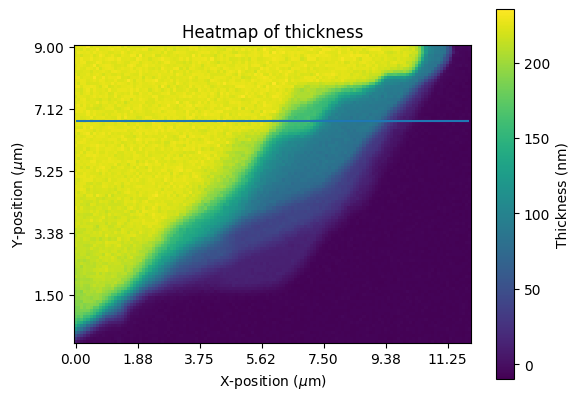

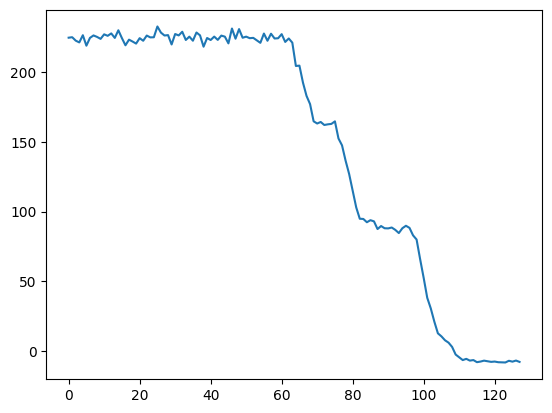

In [37]:
matris = read_mapp_file("mapdata/test128.rpl")
xarray = np.linspace(0,12,10)
yarray = np.linspace(0,9,10)
# plt.imshow(matris, cmap='viridis')
# plt.colorbar(label='Thickness (nm)')
# plt.title("Heatmap of thickness")
# plt.xlabel("X-position")
# plt.xlabel("Y-position")
# plt.show()
print(matris.shape)
def fmty(x,pos):
    return f'{(1-x/96)*9:.2f}'
def fmtx(x,pos):
    return f'{(x/128)*12:.2f}'
fig, ax = plt.subplots()

ax.set_xlabel(r"X-position ($\mu$m)")
ax.set_ylabel(r"Y-position ($\mu$m)")
sak = ax.imshow(matris, cmap='viridis')
fig.colorbar(sak,ax=ax,label='Thickness (nm)')
ax.set_title("Heatmap of thickness")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmtx))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmty))
ax.hlines(24,0,127)
# ax.set_xticks(xarray)
# ax.set_yticks(yarray)
plt.show()
plt.plot(matris[24,:])
plt.show()

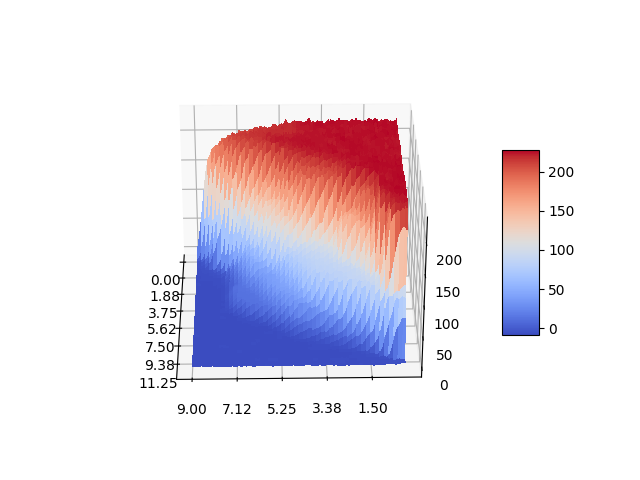

In [34]:
%matplotlib widget

def fmty(x,pos):
    return f'{(1-x/96)*9:.2f}'
def fmtx(x,pos):
    return f'{(x/128)*12:.2f}'

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(0,matris.shape[1])
Y = np.arange(0,matris.shape[0])
X1, Y1 = np.meshgrid(X, Y)
# R = np.sqrt(X**2 + Y**2)
Z = np.fliplr(np.flip(matris))
# Plot the surface.
# print(X1.shape,Y1.shape,Z.shape)
region = np.s_[:192, :256]
x, y, z = X1[region], Y1[region], Z[region]

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(fmtx))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(fmty))

# Add a color bar which maps values to colors.
ax.view_init(40,30)
fig.colorbar(surf, shrink=0.5, aspect=5)
def animate(angle):
    ax.view_init(30, angle)

ani = FuncAnimation(fig, animate, frames=range(360))
writer = animation.PillowWriter(fps=15,metadata=dict(artist='Me'),bitrate=1800)
ani.save('mapping_scale.gif', writer=writer)
plt.show()

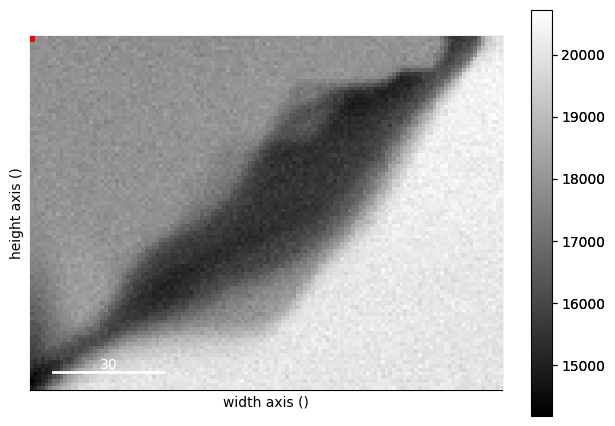

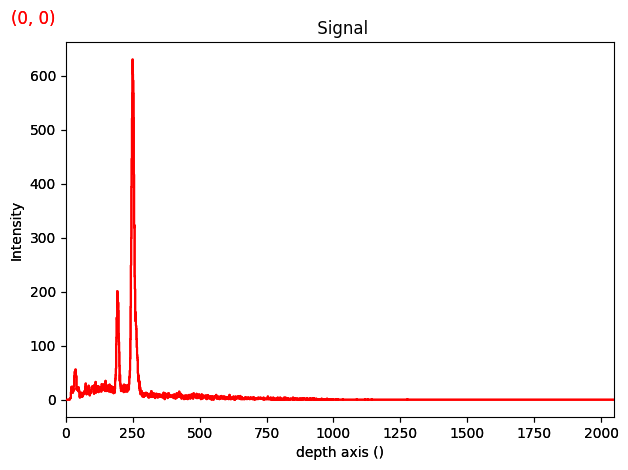

In [17]:
m = hs.load("mapdata/test128.rpl").as_signal1D(0)
# s.set_signal_type('EDS_SEM')
# s.set_elements(["O","S","Mo","Si"])
# s.axes_manager.signal_axes[0].units = 'keV'
# s.axes_manager[2].scale = 0.01
m.plot()

In [ ]:
thickenss = np.zeros([m.data.shape[0],m.data.shape[1]])

a,b =m.axes_manager.signal_extent
array = np.linspace(a,b,m.axes_manager.signal_shape[0])
for i in range(m.data.shape[0]):
    for j in range(m.data.shape[1]):
        data = np.array([array,m.data[i,j,:]]).T
        thickenss[i,j] = predict(data_integration([data])[0],[ 0.00621576,-4.48010331])
        
plt.imshow(thickenss, cmap='viridis')
plt.colorbar(label='Values')
plt.title("Heatmap of thickness")
plt.show()

In [ ]:
a,b =m.axes_manager.signal_extent
array = np.linspace(a,b,m.axes_manager.signal_shape[0])
data = np.array([array,m.data[10,10,:]]).T
plt.plot(array,m.data[10,10,:])

print(predict(data_integration([data])[0],[ 0.00621576,-4.48010331]))
# plt.plot(array,s.data[100,100,:])